In [49]:
import warnings
import torch
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tensor
spikes_tensor = torch.load("tensors/spike_data_tensor.pt" ,map_location=device)
labels_tensor = torch.load("tensors/labels_tensor.pt", map_location=device)

label_distribution = torch.bincount(labels_tensor)
print(f'Original Labels distribution: {label_distribution}')

spikes_tensor = spikes_tensor.to(device)
labels_tensor = labels_tensor.to(device)

Original Labels distribution: tensor([1294,   95, 1046,   53,   40])


In [50]:
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import tonic

class CCMKDataset(Dataset):
    def __init__(self, spikes_tensor, labels_tensor, nchannels=None, target_label=2, seed=None, device=None):
        # Random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        # Move tensors to the specified device
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.spikes_tensor = spikes_tensor.to(device)
        self.labels_tensor = labels_tensor.to(device)

        if nchannels is not None:
            self.spikes_tensor = self.spikes_tensor[:, nchannels, :]
        
        # Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]
        
        # Convert the target label (2) to 1
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Downsampling: Match the number of label 0 samples to the number of label 1 samples
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        #CPU
        # selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False), device=self.device)
        # selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False), device=self.device)

        # GPU
        selected_label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))[:num_samples]].to(self.device)
        selected_label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))[:num_samples]].to(self.device)


        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int().cpu())}")

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        spike_data = self.spikes_tensor[idx]
        label = self.labels_tensor[idx]
        return spike_data, label

### Dataset and DataLoader Configuration

In [51]:
dataset = CCMKDataset(spikes_tensor, labels_tensor, nchannels=list(range(16)), seed=42)

# Balance the dataset by selecting equal samples from both classes
label_0_indices = torch.where(dataset.labels_tensor == 0)[0]
label_1_indices = torch.where(dataset.labels_tensor == 1)[0]

dataset_0 = torch.utils.data.Subset(dataset, label_0_indices)
dataset_1 = torch.utils.data.Subset(dataset, label_1_indices)

# Split size
train_size_0 = int(0.8 * len(dataset_0))
val_size_0 = int(0.1 * len(dataset_0))
test_size_0 = len(dataset_0) - train_size_0 - val_size_0

train_size_1 = int(0.8 * len(dataset_1))
val_size_1 = int(0.1 * len(dataset_1))
test_size_1 = len(dataset_1) - train_size_1 - val_size_1

# Split the dataset
train_dataset_0, val_dataset_0, test_dataset_0 = random_split(dataset_0, [train_size_0, val_size_0, test_size_0], generator=torch.Generator().manual_seed(42))
train_dataset_1, val_dataset_1, test_dataset_1 = random_split(dataset_1, [train_size_1, val_size_1, test_size_1], generator=torch.Generator().manual_seed(42))

# Combine splits from both classes
train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_1])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_0, val_dataset_1])
test_dataset = torch.utils.data.ConcatDataset([test_dataset_0, test_dataset_1])

batch_size = 32
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Filtered Labels distribution after processing: tensor([1046, 1046])


In [52]:
# Adapted from Esther's snn.ipynb notebook

# Check the length of the dataset
print(f"Dataset length: {len(dataset)}")

# Get and print the shape of the first sample in the dataset
first_spikes, first_label = dataset[0]
print(f"Shape of the first spikes tensor: {first_spikes.shape}")
print(f"Label of the first sample: {first_label}")

# Check batch information in the dataloader
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Inputs shape: {inputs.shape}")  # Batch size x Number of channels x Number of time steps
    print(f" - Targets shape: {targets.shape}")
    break  # Only view the first batch

# Get the distribution of labels
labels = torch.cat([batch[1] for batch in train_loader])
print(f'Labels distribution: {torch.bincount(labels.int())}')

Dataset length: 2092
Shape of the first spikes tensor: torch.Size([16, 101])
Label of the first sample: 0
Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Targets shape: torch.Size([32])
Labels distribution: tensor([836, 836])


In [53]:
# Check the shape of tensors in a DataLoader
def check_dataloader_shapes(dataloader, loader_name=""):
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        print(f"Loader: {loader_name}, Batch {batch_idx + 1}:")
        print(f" - Inputs shape: {inputs.shape}")  
        print(f" - Labels shape: {labels.shape}")  
        break 

check_dataloader_shapes(train_loader, "Train Loader")
check_dataloader_shapes(val_loader, "Validation Loader")
check_dataloader_shapes(test_loader, "Test Loader")


Loader: Train Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Validation Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])
Loader: Test Loader, Batch 1:
 - Inputs shape: torch.Size([32, 16, 101])
 - Labels shape: torch.Size([32])


### Network Initialization

In [54]:
import torch
import numpy as np
import random

# Reproducibility
seed = 42  

# Set seed for Python's built-in random module
random.seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Set seed for PyTorch
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [55]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

n_channels = 16  # Number of input channels
n_classes = 1    # Number of output classes
n_time = 101     # Number of time steps

model1 = SynNet(
    n_channels=n_channels,                        
    n_classes=n_classes,                           
    size_hidden_layers=[24, 24, 24],        
    time_constants_per_layer=[2, 4, 8]
)

print(model1)

SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_LinearTorch' with shape (16, 24)
        LIFTorch '1_LIFTorch' with shape (24, 24)
        TimeStepDropout '2_TimeStepDropout' with shape (24,)
        LinearTorch '3_LinearTorch' with shape (24, 24)
        LIFTorch '4_LIFTorch' with shape (24, 24)
        TimeStepDropout '5_TimeStepDropout' with shape (24,)
        LinearTorch '6_LinearTorch' with shape (24, 24)
        LIFTorch '7_LIFTorch' with shape (24, 24)
        TimeStepDropout '8_TimeStepDropout' with shape (24,)
        LinearTorch '9_LinearTorch' with shape (24, 1)
        LIFTorch '10_LIFTorch' with shape (1, 1)
    }
}


### Train & Validation

### Model 1 

  0%|          | 0/50 [00:00<?, ?it/s]

Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.34601253271102905
Inputs max: 23.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.46561264991760254
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.10398492962121964
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: 0.05530087649822235
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 2.787116007647453e-22
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.44900602102279663
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.1677292138338089
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.010783795267343521
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: 0.05290365219116211
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 3.8982306965751334e-12
Layer 10_LIFTorch: Spikes 

  2%|▏         | 1/50 [00:14<12:14, 14.99s/it]

Epoch 1/50, Training Loss: 86.75471698113208, Validation Loss: 53.57142857142857
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3630492091178894
Inputs max: 26.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0002493913343641907
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.00037517983582802117
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -0.27629631757736206
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 1.8090763174433388e-42
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4469175338745117
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.10167644172906876
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.1280413419008255
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -0.3415493071079254
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_

  4%|▍         | 2/50 [00:30<12:02, 15.06s/it]

Epoch 2/50, Training Loss: 50.564268867924525, Validation Loss: 31.71875
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3255530595779419
Inputs max: 25.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -2.8986499309539795
Layer 1_LIFTorch: Spikes sum: 14.0
Layer 4_LIFTorch: Membrane potentials mean: -1.6140999794006348
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -2.8734934329986572
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: 0.06706317514181137
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.36821240186691284
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.8199455142021179
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -1.3810663223266602
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -2.321380376815796
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane 

  6%|▌         | 3/50 [00:45<11:50, 15.12s/it]

Epoch 3/50, Training Loss: 35.168042452830186, Validation Loss: 29.450892857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.46503713726997375
Inputs max: 27.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.3124600648880005
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -0.15887896716594696
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -2.2094147205352783
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 4.760746321608167e-07
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4906984865665436
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.05281622335314751
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.08972257375717163
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -1.6915498971939087
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFT

  8%|▊         | 4/50 [01:01<11:55, 15.56s/it]

Epoch 4/50, Training Loss: 34.80365566037736, Validation Loss: 31.34375
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5091661214828491
Inputs max: 39.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.3482975959777832
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -2.5184285640716553
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -4.11386251449585
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: 0.38055557012557983
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4330909550189972
Inputs max: 27.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.07319337129592896
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.4316560924053192
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -1.825857162475586
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane poten

 10%|█         | 5/50 [01:16<11:31, 15.37s/it]

Epoch 5/50, Training Loss: 32.90978773584906, Validation Loss: 29.107142857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4466854929924011
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.017399271950125694
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.23630893230438232
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -2.8935375213623047
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 1.1903544122615628e-11
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.2703627645969391
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.8540937304496765
Layer 1_LIFTorch: Spikes sum: 7.0
Layer 4_LIFTorch: Membrane potentials mean: -1.2021030187606812
Layer 4_LIFTorch: Spikes sum: 2.0
Layer 7_LIFTorch: Membrane potentials mean: -2.8979270458221436
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTor

 12%|█▏        | 6/50 [01:31<11:09, 15.21s/it]

Epoch 6/50, Training Loss: 30.096698113207548, Validation Loss: 27.392857142857142
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.44927677512168884
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.010090590454638004
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.0017837407067418098
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -1.564196228981018
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 4.1958709974483416e-37
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.40300124883651733
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.10200265049934387
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.3297179937362671
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.815541744232178
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LI

 14%|█▍        | 7/50 [01:45<10:43, 14.96s/it]

Epoch 7/50, Training Loss: 29.369103773584907, Validation Loss: 26.625
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.47940516471862793
Inputs max: 39.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.9795367121696472
Layer 1_LIFTorch: Spikes sum: 6.0
Layer 4_LIFTorch: Membrane potentials mean: -1.7175230979919434
Layer 4_LIFTorch: Spikes sum: 2.0
Layer 7_LIFTorch: Membrane potentials mean: -2.608543872833252
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 1.959117043446543e-37
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.47818687558174133
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.13059942424297333
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -3.3814220428466797
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -6.553785800933838
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane 

 16%|█▌        | 8/50 [02:00<10:23, 14.84s/it]

Epoch 8/50, Training Loss: 28.122051886792452, Validation Loss: 25.883928571428573
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4678798019886017
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.02892930805683136
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.0855426788330078
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -5.294196605682373
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 1.2949976735399105e-05
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4638768434524536
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.750335156917572
Layer 1_LIFTorch: Spikes sum: 6.0
Layer 4_LIFTorch: Membrane potentials mean: -0.4346928596496582
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -2.0892980098724365
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch:

 18%|█▊        | 9/50 [02:15<10:05, 14.78s/it]

Epoch 9/50, Training Loss: 26.93514150943396, Validation Loss: 24.696428571428573
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5461981892585754
Inputs max: 36.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0003173093718942255
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.049496572464704514
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -2.4970595836639404
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 5.607025260756515e-13
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4515586197376251
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.1723771095275879
Layer 1_LIFTorch: Spikes sum: 4.0
Layer 4_LIFTorch: Membrane potentials mean: -1.5016108751296997
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -4.920889377593994
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTo

 20%|██        | 10/50 [02:29<09:50, 14.77s/it]

Epoch 10/50, Training Loss: 26.92983490566038, Validation Loss: 24.513392857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.41011756658554077
Inputs max: 38.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.07013806700706482
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.051604270935058594
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -2.1047115325927734
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -2.5137462260092385e-34
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5225866436958313
Inputs max: 27.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.5268306136131287
Layer 1_LIFTorch: Spikes sum: 4.0
Layer 4_LIFTorch: Membrane potentials mean: -0.5911545753479004
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -1.1886471509933472
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LI

 22%|██▏       | 11/50 [02:44<09:35, 14.76s/it]

Epoch 11/50, Training Loss: 25.37441037735849, Validation Loss: 24.232142857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4657913148403168
Inputs max: 36.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.07031312584877014
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -1.1870450973510742
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.514939308166504
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -4.0896925384004135e-06
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4496828615665436
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.31579461693763733
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -4.712504863739014
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -11.35129165649414
Layer 7_LIFTorch: Spikes sum: 2.0
Layer 10_LIFTorch

 24%|██▍       | 12/50 [02:59<09:19, 14.72s/it]

Epoch 12/50, Training Loss: 24.722287735849058, Validation Loss: 22.080357142857142
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5009475350379944
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.07895267754793167
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -3.0362911224365234
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -8.273967742919922
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: -0.04731066897511482
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.47159266471862793
Inputs max: 25.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.05534632131457329
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.5623326301574707
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.733415126800537
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch:

 26%|██▌       | 13/50 [03:14<09:06, 14.77s/it]

Epoch 13/50, Training Loss: 24.00058962264151, Validation Loss: 22.370535714285715
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5799814462661743
Inputs max: 43.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.004488927777856588
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.06370190531015396
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -2.605391502380371
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -3.5846058126291464e-28
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5075610876083374
Inputs max: 39.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.04715784266591072
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -2.0019376277923584
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -1.95449960231781
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorc

 28%|██▊       | 14/50 [03:28<08:52, 14.78s/it]

Epoch 14/50, Training Loss: 22.7376179245283, Validation Loss: 22.8125
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.43036431074142456
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.1665804386138916
Layer 1_LIFTorch: Spikes sum: 9.0
Layer 4_LIFTorch: Membrane potentials mean: -3.1960620880126953
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -7.365942478179932
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.1099245548248291
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.42013460397720337
Inputs max: 36.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.03812088072299957
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -0.6358523964881897
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.989292144775391
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane po

 30%|███       | 15/50 [03:43<08:37, 14.79s/it]

Epoch 15/50, Training Loss: 23.058962264150942, Validation Loss: 20.339285714285715
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.44173499941825867
Inputs max: 22.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.03781932592391968
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.9584590196609497
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -3.357675313949585
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -8.456523422351137e-28
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.42719292640686035
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.4616217613220215
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -0.6302165389060974
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -1.6305294036865234
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTo

 32%|███▏      | 16/50 [03:58<08:23, 14.80s/it]

Epoch 16/50, Training Loss: 22.265919811320753, Validation Loss: 20.794642857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.48739171028137207
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.08325298875570297
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.4209631383419037
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.214075565338135
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.044313788414001465
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5036355257034302
Inputs max: 44.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.01898086816072464
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.05854417011141777
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -2.5251588821411133
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTor

 34%|███▍      | 17/50 [04:13<08:07, 14.76s/it]

Epoch 17/50, Training Loss: 21.837853773584907, Validation Loss: 20.709821428571427
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4671643078327179
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.245383620262146
Layer 1_LIFTorch: Spikes sum: 9.0
Layer 4_LIFTorch: Membrane potentials mean: -6.841178894042969
Layer 4_LIFTorch: Spikes sum: 5.0
Layer 7_LIFTorch: Membrane potentials mean: -11.934075355529785
Layer 7_LIFTorch: Spikes sum: 6.0
Layer 10_LIFTorch: Membrane potentials mean: 0.23297668993473053
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3052096366882324
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.13228927552700043
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.6039146184921265
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.913076400756836
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: M

 36%|███▌      | 18/50 [04:27<07:50, 14.70s/it]

Epoch 18/50, Training Loss: 22.640919811320753, Validation Loss: 20.294642857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5038675665855408
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.02472286857664585
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -1.7689892053604126
Layer 4_LIFTorch: Spikes sum: 2.0
Layer 7_LIFTorch: Membrane potentials mean: -3.399866819381714
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 0.027185488492250443
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4633934199810028
Inputs max: 25.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.11570795625448227
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.80534029006958
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.599088191986084
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Me

 38%|███▊      | 19/50 [04:42<07:34, 14.66s/it]

Epoch 19/50, Training Loss: 21.68926886792453, Validation Loss: 19.129464285714285
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4365137815475464
Inputs max: 27.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.02918314002454281
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.28276851773262024
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -5.942108154296875
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.061678316444158554
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.43546953797340393
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0032654504757374525
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.3704744577407837
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.933332443237305
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFT

 40%|████      | 20/50 [04:56<07:18, 14.60s/it]

Epoch 20/50, Training Loss: 20.691627358490567, Validation Loss: 18.683035714285715
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5274598002433777
Inputs max: 37.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.015213035978376865
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.333971232175827
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -5.81431770324707
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -3.543632919900119e-05
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.38532641530036926
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0741875097155571
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.31531670689582825
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -3.3615167140960693
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTor

 42%|████▏     | 21/50 [05:11<07:03, 14.59s/it]

Epoch 21/50, Training Loss: 20.653301886792452, Validation Loss: 18.294642857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4378480911254883
Inputs max: 27.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.23506194353103638
Layer 1_LIFTorch: Spikes sum: 4.0
Layer 4_LIFTorch: Membrane potentials mean: -0.13268129527568817
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.934741973876953
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -1.872643343560701e-13
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4267868101596832
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.36533108353614807
Layer 1_LIFTorch: Spikes sum: 5.0
Layer 4_LIFTorch: Membrane potentials mean: -3.3206100463867188
Layer 4_LIFTorch: Spikes sum: 2.0
Layer 7_LIFTorch: Membrane potentials mean: -4.231250762939453
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTo

 44%|████▍     | 22/50 [05:26<06:49, 14.62s/it]

Epoch 22/50, Training Loss: 19.993514150943398, Validation Loss: 17.598214285714285
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4468788802623749
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.11336871236562729
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -5.3007283210754395
Layer 4_LIFTorch: Spikes sum: 4.0
Layer 7_LIFTorch: Membrane potentials mean: -14.652070045471191
Layer 7_LIFTorch: Spikes sum: 4.0
Layer 10_LIFTorch: Membrane potentials mean: 0.2358427345752716
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.43744197487831116
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.06765910238027573
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -3.3176982402801514
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -9.018994331359863
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch

 46%|████▌     | 23/50 [05:40<06:36, 14.68s/it]

Epoch 23/50, Training Loss: 19.631485849056602, Validation Loss: 16.763392857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4334583878517151
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.43952855467796326
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -5.901372909545898
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -14.40787124633789
Layer 7_LIFTorch: Spikes sum: 3.0
Layer 10_LIFTorch: Membrane potentials mean: -0.1586366444826126
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.39544013142585754
Inputs max: 44.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.0041024163365364075
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.02197018824517727
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.3598246574401855
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTor

 48%|████▊     | 24/50 [05:55<06:23, 14.76s/it]

Epoch 24/50, Training Loss: 18.79245283018868, Validation Loss: 16.316964285714285
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5665029287338257
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.013912332244217396
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.22114096581935883
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -2.9754724502563477
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -2.2037340914342194e-26
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.38519105315208435
Inputs max: 25.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.04705578461289406
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.8903960585594177
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.082743167877197
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LI

 50%|█████     | 25/50 [06:10<06:09, 14.79s/it]

Epoch 25/50, Training Loss: 18.704599056603772, Validation Loss: 15.928571428571429
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.47551825642585754
Inputs max: 44.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.010005851276218891
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -3.0160233974456787
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.777156829833984
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.13012628257274628
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5006188154220581
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.0007264086161740124
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.056143272668123245
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -3.5796873569488525
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LI

 52%|█████▏    | 26/50 [06:25<05:54, 14.77s/it]

Epoch 26/50, Training Loss: 18.82075471698113, Validation Loss: 16.84375
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4483872354030609
Inputs max: 35.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.6901890635490417
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -1.009670615196228
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -8.93209171295166
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: -0.374562531709671
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.6468324661254883
Inputs max: 37.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.014092189259827137
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.7107423543930054
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -11.434237480163574
Layer 7_LIFTorch: Spikes sum: 2.0
Layer 10_LIFTorch: Membrane pote

 54%|█████▍    | 27/50 [06:40<05:40, 14.81s/it]

Epoch 27/50, Training Loss: 18.03125, Validation Loss: 15.700892857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.35175588726997375
Inputs max: 21.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.5053021311759949
Layer 1_LIFTorch: Spikes sum: 5.0
Layer 4_LIFTorch: Membrane potentials mean: -4.517277240753174
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -10.564006805419922
Layer 7_LIFTorch: Spikes sum: 2.0
Layer 10_LIFTorch: Membrane potentials mean: 0.15563641488552094
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4059986174106598
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.16927479207515717
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -3.176832437515259
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -11.600227355957031
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane 

 56%|█████▌    | 28/50 [06:54<05:23, 14.69s/it]

Epoch 28/50, Training Loss: 17.67865566037736, Validation Loss: 15.504464285714286
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4329749345779419
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.5837131142616272
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -6.909381866455078
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -11.9537935256958
Layer 7_LIFTorch: Spikes sum: 5.0
Layer 10_LIFTorch: Membrane potentials mean: 0.4413059949874878
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.48236384987831116
Inputs max: 35.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.6776293516159058
Layer 1_LIFTorch: Spikes sum: 13.0
Layer 4_LIFTorch: Membrane potentials mean: -2.2784335613250732
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -8.595844268798828
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Mem

 58%|█████▊    | 29/50 [07:09<05:06, 14.61s/it]

Epoch 29/50, Training Loss: 17.58431603773585, Validation Loss: 17.665178571428573
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.42756032943725586
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.012925863265991211
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.4648034870624542
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -3.267399787902832
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -6.690439284668066e-25
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5805035829544067
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.03048301674425602
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.9265594482421875
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -2.7395660877227783
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTo

 60%|██████    | 30/50 [07:23<04:49, 14.49s/it]

Epoch 30/50, Training Loss: 17.1126179245283, Validation Loss: 15.575892857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.45037901401519775
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.03281471133232117
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.67254638671875
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -9.15712833404541
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: -0.2780013084411621
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4835434854030609
Inputs max: 26.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.16622671484947205
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.10454397648572922
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -3.666638135910034
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Me

 62%|██████▏   | 31/50 [07:37<04:34, 14.43s/it]

Epoch 31/50, Training Loss: 17.11438679245283, Validation Loss: 15.861607142857142
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5053179264068604
Inputs max: 36.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.24385178089141846
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -6.74080228805542
Layer 4_LIFTorch: Spikes sum: 5.0
Layer 7_LIFTorch: Membrane potentials mean: -11.625144958496094
Layer 7_LIFTorch: Spikes sum: 4.0
Layer 10_LIFTorch: Membrane potentials mean: 0.8121387958526611
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4472849667072296
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.45282459259033203
Layer 1_LIFTorch: Spikes sum: 6.0
Layer 4_LIFTorch: Membrane potentials mean: -1.2323259115219116
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -8.139008522033691
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Me

 64%|██████▍   | 32/50 [07:51<04:19, 14.40s/it]

Epoch 32/50, Training Loss: 17.747051886792452, Validation Loss: 15.388392857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.48273128271102905
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.15823857486248016
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.4117035865783691
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.061615467071533
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 0.004487482365220785
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.45830756425857544
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0520753376185894
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.17997466027736664
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -7.12634801864624
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorc

 66%|██████▌   | 33/50 [08:06<04:04, 14.35s/it]

Epoch 33/50, Training Loss: 16.527122641509433, Validation Loss: 15.491071428571429
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.48799118399620056
Inputs max: 43.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -2.386690855026245
Layer 1_LIFTorch: Spikes sum: 16.0
Layer 4_LIFTorch: Membrane potentials mean: -3.5567119121551514
Layer 4_LIFTorch: Spikes sum: 4.0
Layer 7_LIFTorch: Membrane potentials mean: -7.774771213531494
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -2.582815614005085e-05
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4750928282737732
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -2.184757249779068e-06
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.24876810610294342
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.595100402832031
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIF

 68%|██████▊   | 34/50 [08:20<03:49, 14.32s/it]

Epoch 34/50, Training Loss: 16.15507075471698, Validation Loss: 15.071428571428571
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5561378598213196
Inputs max: 38.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 2.215459149468302e-09
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.021648526191711426
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.866030693054199
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -2.3985490676947663e-11
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4371325671672821
Inputs max: 39.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -8.987052774059659e-14
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -3.1806488550500944e-05
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -2.2562062740325928
Layer 7_LIFTorch: Spikes sum: 0.0
Layer

 70%|███████   | 35/50 [08:34<03:35, 14.37s/it]

Epoch 35/50, Training Loss: 16.58313679245283, Validation Loss: 16.879464285714285
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5289294719696045
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.00020025065168738365
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.06273630261421204
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.428619861602783
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 4.986046575616854e-10
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.44939279556274414
Inputs max: 39.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.026065265759825706
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.4360835552215576
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.766693115234375
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIF

 72%|███████▏  | 36/50 [08:49<03:20, 14.32s/it]

Epoch 36/50, Training Loss: 17.235259433962263, Validation Loss: 14.790178571428571
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.44587329030036926
Inputs max: 27.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.014630650170147419
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.2762719690799713
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -8.15065860748291
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: -0.3260495662689209
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.6010403633117676
Inputs max: 26.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.06738198548555374
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -4.013725757598877
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -13.376290321350098
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch:

 74%|███████▍  | 37/50 [09:03<03:06, 14.38s/it]

Epoch 37/50, Training Loss: 15.987617924528301, Validation Loss: 14.714285714285714
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5257193446159363
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.0006719899247400463
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.22398902475833893
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -7.134154796600342
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.1412329375743866
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4303256571292877
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.4386865198612213
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -4.915496349334717
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -13.35161304473877
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch:

 76%|███████▌  | 38/50 [09:18<02:53, 14.47s/it]

Epoch 38/50, Training Loss: 15.689268867924529, Validation Loss: 15.65625
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3753674328327179
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.011116216890513897
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.5922378897666931
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.288351058959961
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 6.813471600253251e-07
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.39934638142585754
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.12423918396234512
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.6658728718757629
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -11.934890747070312
Layer 7_LIFTorch: Spikes sum: 3.0
Layer 10_LIFTorch: Memb

 78%|███████▊  | 39/50 [09:33<02:40, 14.60s/it]

Epoch 39/50, Training Loss: 16.409787735849058, Validation Loss: 18.410714285714285
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5273824334144592
Inputs max: 44.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.8538193106651306
Layer 1_LIFTorch: Spikes sum: 11.0
Layer 4_LIFTorch: Membrane potentials mean: -2.164807081222534
Layer 4_LIFTorch: Spikes sum: 5.0
Layer 7_LIFTorch: Membrane potentials mean: -9.225561141967773
Layer 7_LIFTorch: Spikes sum: 4.0
Layer 10_LIFTorch: Membrane potentials mean: -0.05193186178803444
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.42361539602279663
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.044900909066200256
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.00942791998386383
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -3.3746795654296875
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTo

 80%|████████  | 40/50 [09:48<02:26, 14.64s/it]

Epoch 40/50, Training Loss: 16.440448113207548, Validation Loss: 16.816964285714285
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5360844731330872
Inputs max: 36.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -2.464850425720215
Layer 1_LIFTorch: Spikes sum: 18.0
Layer 4_LIFTorch: Membrane potentials mean: -14.726417541503906
Layer 4_LIFTorch: Spikes sum: 7.0
Layer 7_LIFTorch: Membrane potentials mean: -19.01573371887207
Layer 7_LIFTorch: Spikes sum: 5.0
Layer 10_LIFTorch: Membrane potentials mean: -0.13175088167190552
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.489480197429657
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.02246108092367649
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.015024806372821331
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.443267345428467
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch

 82%|████████▏ | 41/50 [10:02<02:12, 14.67s/it]

Epoch 41/50, Training Loss: 15.748231132075471, Validation Loss: 16.441964285714285
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.49849164485931396
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.6850214004516602
Layer 1_LIFTorch: Spikes sum: 15.0
Layer 4_LIFTorch: Membrane potentials mean: -7.481015682220459
Layer 4_LIFTorch: Spikes sum: 6.0
Layer 7_LIFTorch: Membrane potentials mean: -10.027353286743164
Layer 7_LIFTorch: Spikes sum: 3.0
Layer 10_LIFTorch: Membrane potentials mean: -0.20142003893852234
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4188389480113983
Inputs max: 27.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.7446410655975342
Layer 1_LIFTorch: Spikes sum: 8.0
Layer 4_LIFTorch: Membrane potentials mean: -7.211645603179932
Layer 4_LIFTorch: Spikes sum: 4.0
Layer 7_LIFTorch: Membrane potentials mean: -13.22278118133545
Layer 7_LIFTorch: Spikes sum: 6.0
Layer 10_LIFTorch:

 84%|████████▍ | 42/50 [10:17<01:57, 14.65s/it]

Epoch 42/50, Training Loss: 15.27063679245283, Validation Loss: 15.883928571428571
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5473584532737732
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.4570080041885376
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -7.623188018798828
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -16.774988174438477
Layer 7_LIFTorch: Spikes sum: 6.0
Layer 10_LIFTorch: Membrane potentials mean: -0.1721266210079193
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.41926437616348267
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.008273474872112274
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.0244075059890747
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -11.580490112304688
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch:

 86%|████████▌ | 43/50 [10:32<01:42, 14.67s/it]

Epoch 43/50, Training Loss: 15.285966981132075, Validation Loss: 15.084821428571429
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4252784550189972
Inputs max: 26.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.32579633593559265
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -2.097994804382324
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -9.509644508361816
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.00019667853484861553
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4507077634334564
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.029931098222732544
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.4547032117843628
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -13.311711311340332
Layer 7_LIFTorch: Spikes sum: 2.0
Layer 10_LIFT

 88%|████████▊ | 44/50 [10:46<01:27, 14.65s/it]

Epoch 44/50, Training Loss: 15.492924528301886, Validation Loss: 14.223214285714286
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.44196704030036926
Inputs max: 37.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -2.7944744500178753e-13
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.002722635166719556
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -3.6031463146209717
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -2.5876904877490792e-23
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.46490177512168884
Inputs max: 25.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -2.4947903156280518
Layer 1_LIFTorch: Spikes sum: 17.0
Layer 4_LIFTorch: Membrane potentials mean: -7.77752161026001
Layer 4_LIFTorch: Spikes sum: 6.0
Layer 7_LIFTorch: Membrane potentials mean: -13.038262367248535
Layer 7_LIFTorch: Spikes sum: 3.0
Layer 1

 90%|█████████ | 45/50 [11:01<01:13, 14.71s/it]

Epoch 45/50, Training Loss: 14.79245283018868, Validation Loss: 14.616071428571429
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5315787196159363
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.004547228571027517
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.7236658930778503
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -5.263501167297363
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 0.08829599618911743
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4309444725513458
Inputs max: 36.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.3586024045944214
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.8030722737312317
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -5.822975158691406
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: 

 92%|█████████▏| 46/50 [11:15<00:58, 14.58s/it]

Epoch 46/50, Training Loss: 15.632665094339623, Validation Loss: 14.946428571428571
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.48503249883651733
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.8499863147735596
Layer 1_LIFTorch: Spikes sum: 11.0
Layer 4_LIFTorch: Membrane potentials mean: -4.745612144470215
Layer 4_LIFTorch: Spikes sum: 5.0
Layer 7_LIFTorch: Membrane potentials mean: -9.577845573425293
Layer 7_LIFTorch: Spikes sum: 5.0
Layer 10_LIFTorch: Membrane potentials mean: 0.16841650009155273
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.37165454030036926
Inputs max: 27.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.1155763790011406
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.7568238973617554
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.050152778625488
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch:

 94%|█████████▍| 47/50 [11:30<00:43, 14.57s/it]

Epoch 47/50, Training Loss: 14.741745283018869, Validation Loss: 15.745535714285714
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4321240782737732
Inputs max: 37.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.4949513673782349
Layer 1_LIFTorch: Spikes sum: 9.0
Layer 4_LIFTorch: Membrane potentials mean: -3.6648261547088623
Layer 4_LIFTorch: Spikes sum: 4.0
Layer 7_LIFTorch: Membrane potentials mean: -5.703404903411865
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: 0.35113945603370667
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.46037670969963074
Inputs max: 43.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.7583813667297363
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -4.078228950500488
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -8.188149452209473
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: M

 96%|█████████▌| 48/50 [11:45<00:29, 14.64s/it]

Epoch 48/50, Training Loss: 14.46816037735849, Validation Loss: 15.5
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4516553282737732
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.5547298192977905
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -6.2132954597473145
Layer 4_LIFTorch: Spikes sum: 2.0
Layer 7_LIFTorch: Membrane potentials mean: -15.396830558776855
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: -0.3763350248336792
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3950147032737732
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -3.1448323056793015e-08
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.007790898438543081
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.3567023277282715
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane

 98%|█████████▊| 49/50 [11:59<00:14, 14.63s/it]

Epoch 49/50, Training Loss: 14.52181603773585, Validation Loss: 15.397321428571429
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.44038134813308716
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -4.75697306683287e-05
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.11220528930425644
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -3.855901002883911
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -1.5800473723906152e-23
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.515934407711029
Inputs max: 43.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.3321911692619324
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -2.8660411834716797
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -10.33875846862793
Layer 7_LIFTorch: Spikes sum: 2.0
Layer 10_LIFTo

100%|██████████| 50/50 [12:14<00:00, 14.69s/it]

Epoch 50/50, Training Loss: 14.726415094339623, Validation Loss: 14.584821428571429


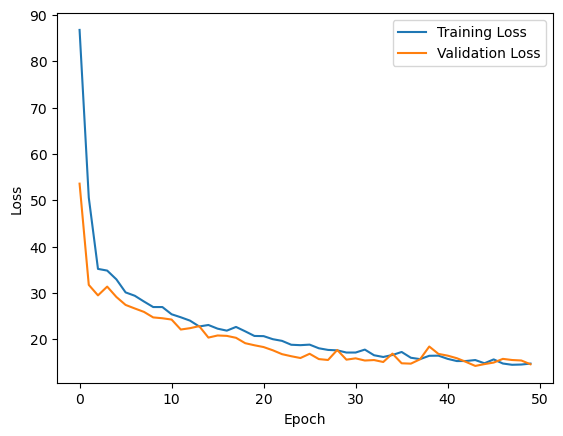

In [56]:
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)

# Hyperparameters
n_epochs = 50
learning_rate = 1e-3
target_firing_rate_value = 10  

optimizer = Adam(model1.parameters().astorch(), lr=learning_rate)
loss_fun = MSELoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Store membrane potentials, spikes, syn currents
membrane_potentials = []
spike_outputs = []
synaptic_currents = []

# Store predictions and ground truth
predictions = []
ground_truths = []

# Training phase
for epoch in trange(n_epochs):
    model1.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1).to(device)

        # Inspect the inputs
        print("Inputs shape:", inputs.shape)
        print("Inputs mean:", inputs.mean().item())
        print("Inputs max:", inputs.max().item())
        print("Inputs min:", inputs.min().item())

        optimizer.zero_grad()
        outputs, _, _ = model1(inputs)
        outputs_sum = outputs.sum(dim=1)  # Sum over the time dimension

        # target firing rate tensor
        target_firing_rate = torch.zeros_like(outputs_sum).to(device)
        target_firing_rate[labels == 1] = target_firing_rate_value
        target_firing_rate[labels == 0] = 0

        # Compute loss
        loss = loss_fun(outputs_sum, target_firing_rate)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if epoch == n_epochs - 1:
            predictions.append(outputs_sum.detach().cpu().numpy())  # Final output (spike prediction)
            ground_truths.append(labels.cpu().numpy()) 
        
        # Access internal layer membrane potentials and spikes
        for lyr_name in model1.lif_names:
            lyr = model1.seq[lyr_name]

            # Inspect membrane potentials and spikes
            print(f"Layer {lyr_name}: Membrane potentials mean:", lyr.vmem.mean().item())
            print(f"Layer {lyr_name}: Spikes sum:", lyr.spikes.sum().item())  # Sum of spikes should be > 0 if neurons are firing
            
            v_mem = lyr.vmem.detach().cpu().numpy()  # Membrane potentials
            spikes = lyr.spikes.detach().cpu().numpy()  # Spikes
            i_syn = lyr.isyn.detach().cpu().numpy()  # Synaptic currents
            
            # Store for visualization
            membrane_potentials.append(v_mem)
            spike_outputs.append(spikes)
            synaptic_currents.append(i_syn)

    train_losses.append(epoch_loss / len(train_loader))

    # Validation phase
    model1.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1).to(device)
            outputs, _, _ = model1(inputs)
            outputs_sum = outputs.sum(dim=1)
            target_firing_rate = torch.zeros_like(outputs_sum).to(device)
            target_firing_rate[labels == 1] = target_firing_rate_value
            target_firing_rate[labels == 0] = 0
            loss = loss_fun(outputs_sum, target_firing_rate)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

predictions = np.concatenate(predictions)
ground_truths = np.concatenate(ground_truths)

# Save results
model1_outputs = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'membrane_potentials': membrane_potentials,
    'spike_outputs': spike_outputs,
    'synaptic_currents': synaptic_currents,
    'predictions': predictions,  
    'ground_truths': ground_truths
}

with open('model1_outputs.pkl', 'wb') as f:
    pickle.dump(model1_outputs, f)
    
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 1 Visualization

In [57]:
import pickle

with open('model1_outputs.pkl', 'rb') as f:
    model1_outputs = pickle.load(f)

# Extract the saved outputs
train_losses = model1_outputs['train_losses']
val_losses = model1_outputs['val_losses']
membrane_potentials = model1_outputs['membrane_potentials']
spike_outputs = model1_outputs['spike_outputs']

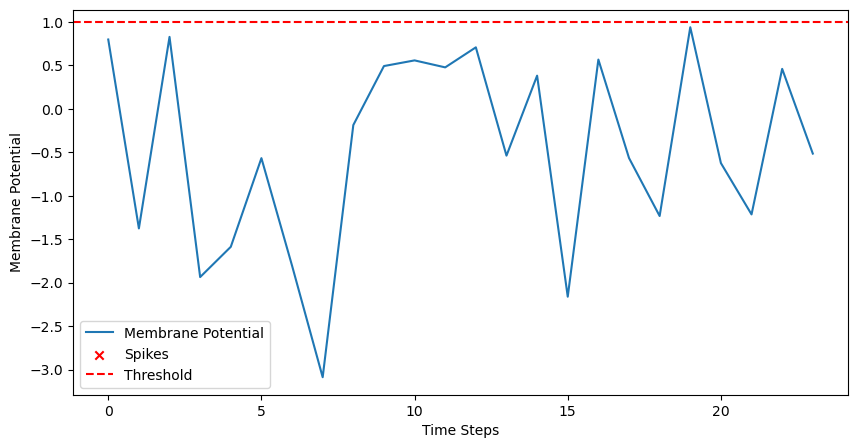

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming spikes are binary (0 or 1)
plt.figure(figsize=(10, 5))

# Plot membrane potential
plt.plot(membrane_potentials[0].squeeze(), label='Membrane Potential')

# Plot spikes as vertical lines where spikes occur
spike_times = np.where(spike_outputs[0].squeeze() > 0)[0]  # Find time steps where spikes occur
plt.scatter(spike_times, np.ones_like(spike_times) * 0, color='red', label='Spikes', marker='x')

# Threshold
plt.axhline(y=1, color='r', linestyle='--', label='Threshold')  # Assuming the default threshold is 1

plt.xlabel('Time Steps')
plt.ylabel('Membrane Potential')
plt.legend()
plt.show()


In [59]:
print(spike_outputs[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


- Visualization across network

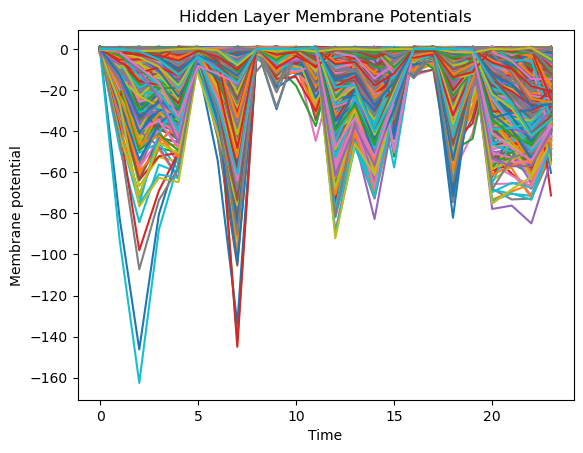

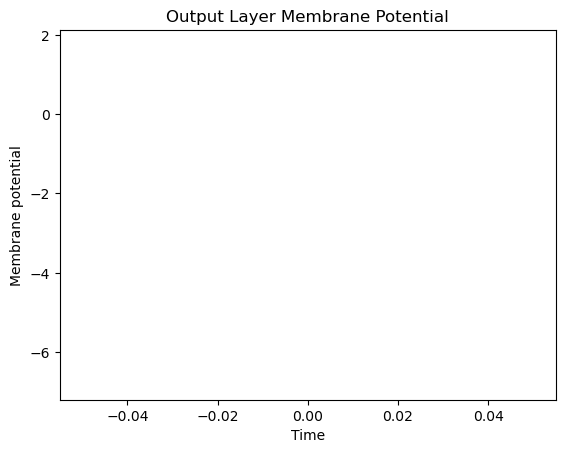

In [60]:
# Plot hidden layer membrane potentials
hidden_potentials = np.array([p for p in membrane_potentials if len(p) == 24])
plt.plot(hidden_potentials.T)
plt.xlabel("Time")
plt.ylabel("Membrane potential")
plt.title("Hidden Layer Membrane Potentials")
plt.show()

# Plot output layer membrane potential
output_potential = np.array([p for p in membrane_potentials if len(p) == 1])
plt.plot(output_potential.T)
plt.xlabel("Time")
plt.ylabel("Membrane potential")
plt.title("Output Layer Membrane Potential")
plt.show()


In [ ]:
# Check the content of output potentials
output_potential = [p for p in membrane_potentials if len(p) == 1]
print("Output layer potential values:", output_potential)


Accuracy with threshold 1: 50.00%
Accuracy with threshold 3: 50.00%
Accuracy with threshold 5: 50.00%
Accuracy with threshold 10: 50.00%


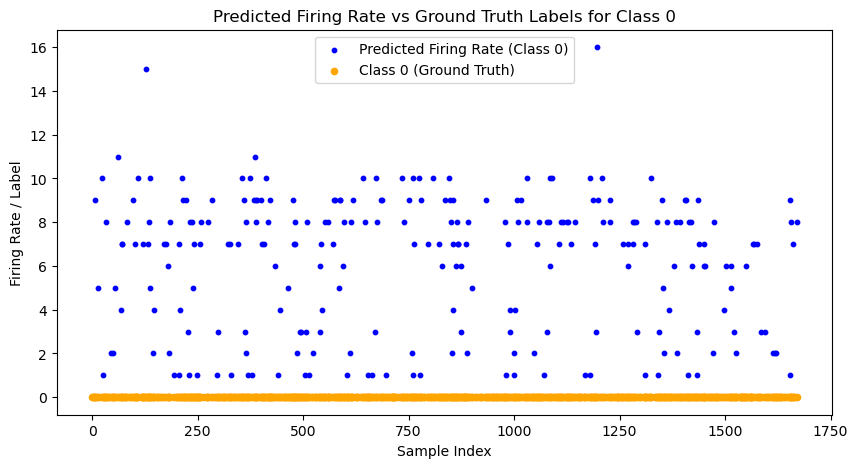

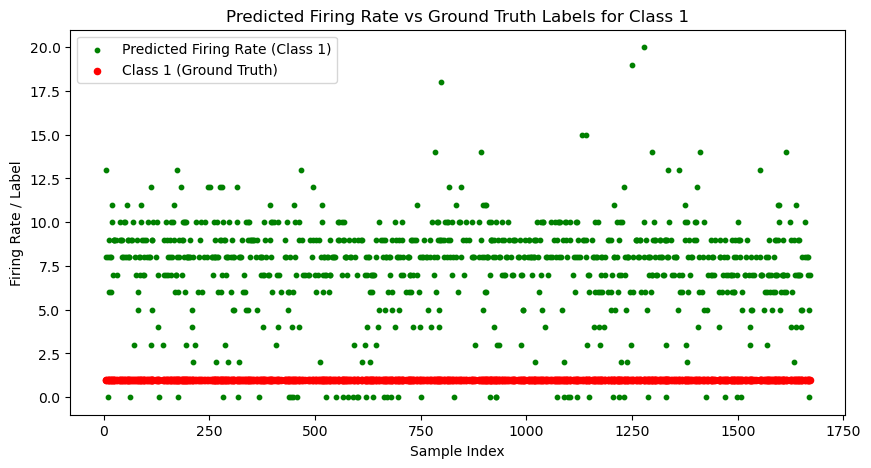

In [63]:
import matplotlib.pyplot as plt
import numpy as np

predictions = np.array(predictions)
ground_truths = np.array(ground_truths)

class_0_indices = ground_truths == 0
class_1_indices = ground_truths == 1

# Experiment with different thresholds
for threshold in [1, 3, 5, 10]:
    predicted_classes = (predictions > threshold).astype(int)
    accuracy = np.mean(predicted_classes == ground_truths)
    print(f'Accuracy with threshold {threshold}: {accuracy * 100:.2f}%')

# Plot for Class 0
plt.figure(figsize=(10, 5))
plt.scatter(np.where(class_0_indices)[0], predictions[class_0_indices], label='Predicted Firing Rate (Class 0)', color='blue', s=10)
plt.scatter(np.where(class_0_indices)[0], ground_truths[class_0_indices], label='Class 0 (Ground Truth)', color='orange', s=20)
plt.xlabel('Sample Index')
plt.ylabel('Firing Rate / Label')
plt.title('Predicted Firing Rate vs Ground Truth Labels for Class 0')
plt.legend()
plt.show()

# Plot for Class 1
plt.figure(figsize=(10, 5))
plt.scatter(np.where(class_1_indices)[0], predictions[class_1_indices], label='Predicted Firing Rate (Class 1)', color='green', s=10)
plt.scatter(np.where(class_1_indices)[0], ground_truths[class_1_indices], label='Class 1 (Ground Truth)', color='red', s=20)
plt.xlabel('Sample Index')
plt.ylabel('Firing Rate / Label')
plt.title('Predicted Firing Rate vs Ground Truth Labels for Class 1')
plt.legend()
plt.show()

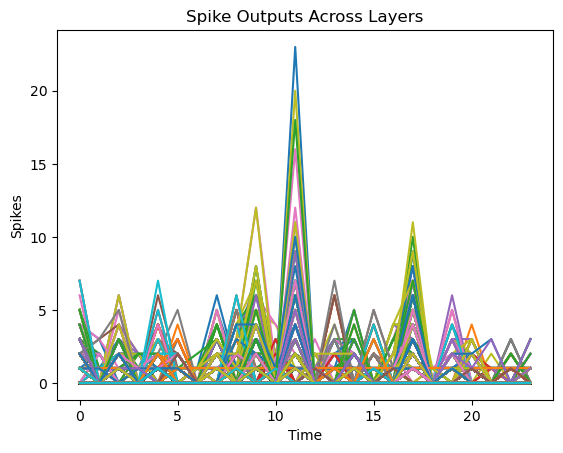

In [62]:
padded_spikes = []
for spikes in spike_outputs:
    if spikes.shape == (24,):
        padded_spikes.append(spikes)
    elif spikes.shape == (1,):
        padded_spikes.append(np.repeat(spikes, 24)) 

padded_spikes = np.array(padded_spikes)

plt.plot(padded_spikes.T)
plt.xlabel("Time")
plt.ylabel("Spikes")
plt.title("Spike Outputs Across Layers")
plt.show()

- Visualization of specific layers

In [37]:
import numpy as np

# Pad the output layer's membrane potentials to match the shape of the hidden layers
padded_potentials = []
for potentials in membrane_potentials:
    if potentials.shape == (24,):
        padded_potentials.append(potentials)
    elif potentials.shape == (1,):
        padded_potentials.append(np.repeat(potentials, 24))  # Repeat to match the shape (24,)

# Convert the padded list into a numpy array for plotting
padded_potentials = np.array(padded_potentials)


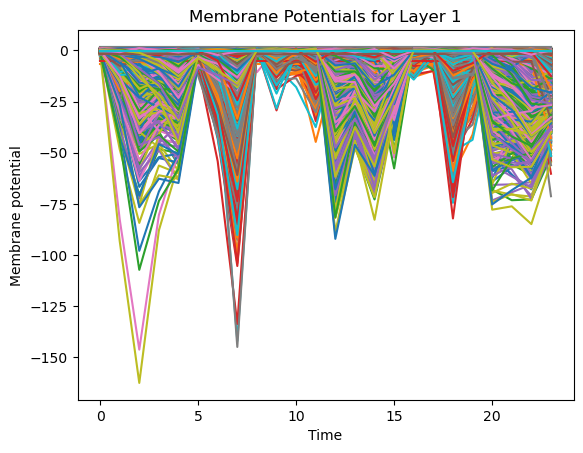

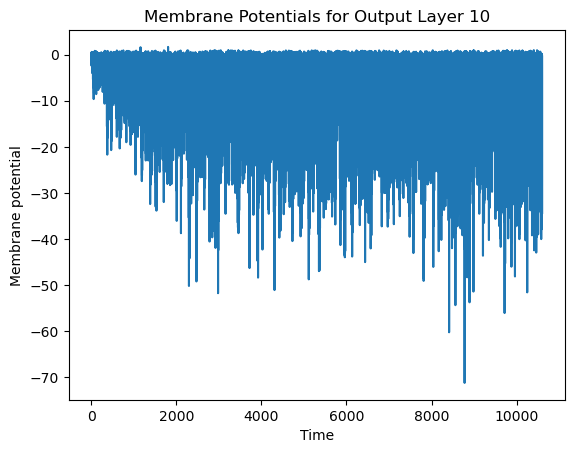

In [38]:
# Plot membrane potentials for the first hidden layer and output layer
layer_to_plot_hidden = 1  # First hidden layer
layer_to_plot_output = 10  # Output layer

# Membrane potential for first hidden layer
mem_pot_hidden_layer = padded_potentials[:, :24]  # First 24 neurons for the hidden layer
plt.plot(mem_pot_hidden_layer.T)
plt.xlabel("Time")
plt.ylabel("Membrane potential")
plt.title(f"Membrane Potentials for Layer {layer_to_plot_hidden}")
plt.show()

# Membrane potential for output layer (last layer)
mem_pot_output_layer = padded_potentials[:, -1]  # Output layer (single neuron, repeated 24 times for plotting)
plt.plot(mem_pot_output_layer.T)
plt.xlabel("Time")
plt.ylabel("Membrane potential")
plt.title(f"Membrane Potentials for Output Layer {layer_to_plot_output}")
plt.show()


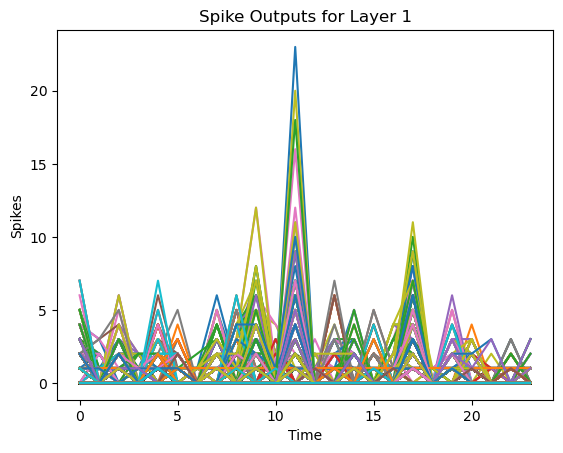

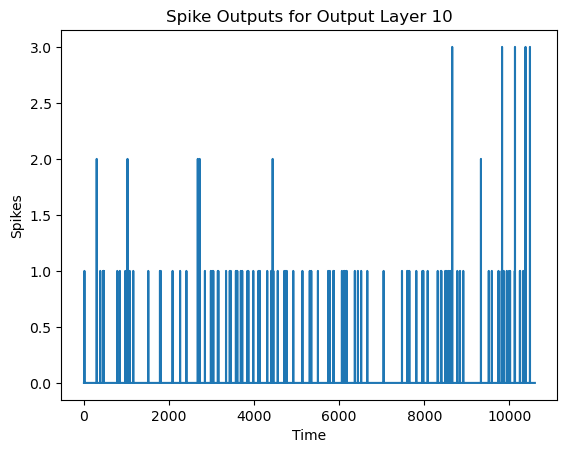

In [39]:
# Spike outputs for first hidden layer
spike_hidden_layer = padded_spikes[:, :24]  # First 24 neurons for the hidden layer
plt.plot(spike_hidden_layer.T)
plt.xlabel("Time")
plt.ylabel("Spikes")
plt.title(f"Spike Outputs for Layer {layer_to_plot_hidden}")
plt.show()

# Spike outputs for output layer (last layer)
spike_output_layer = padded_spikes[:, -1]  # Output layer (single neuron, repeated 24 times for plotting)
plt.plot(spike_output_layer.T)
plt.xlabel("Time")
plt.ylabel("Spikes")
plt.title(f"Spike Outputs for Output Layer {layer_to_plot_output}")
plt.show()


- Visualization on a smaller time range (allows for better visualization of how spikes occur within a few time steps)

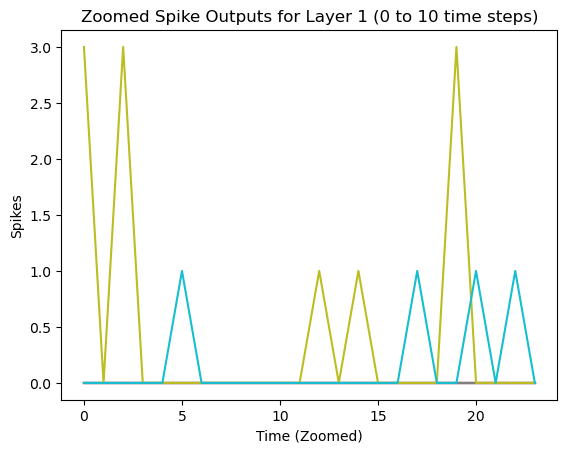

In [40]:
# Zoom in on first 10 time steps for the first hidden layer (spike outputs)
zoomed_time_range = 10  # First 10 time steps
spike_hidden_layer_zoomed = padded_spikes[:zoomed_time_range, :24]  # First 24 neurons for the hidden layer
plt.plot(spike_hidden_layer_zoomed.T)
plt.xlabel("Time (Zoomed)")
plt.ylabel("Spikes")
plt.title(f"Zoomed Spike Outputs for Layer {layer_to_plot_hidden} (0 to {zoomed_time_range} time steps)")
plt.show()


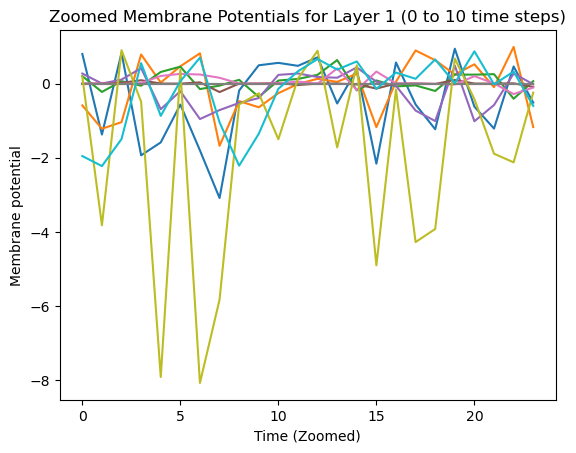

In [41]:
# Zoom in on first 10 time steps for the first hidden layer (membrane potentials)
mem_pot_hidden_layer_zoomed = padded_potentials[:zoomed_time_range, :24]  # First 24 neurons for the hidden layer
plt.plot(mem_pot_hidden_layer_zoomed.T)
plt.xlabel("Time (Zoomed)")
plt.ylabel("Membrane potential")
plt.title(f"Zoomed Membrane Potentials for Layer {layer_to_plot_hidden} (0 to {zoomed_time_range} time steps)")
plt.show()


- Visualization of comparison of inputs and outputs

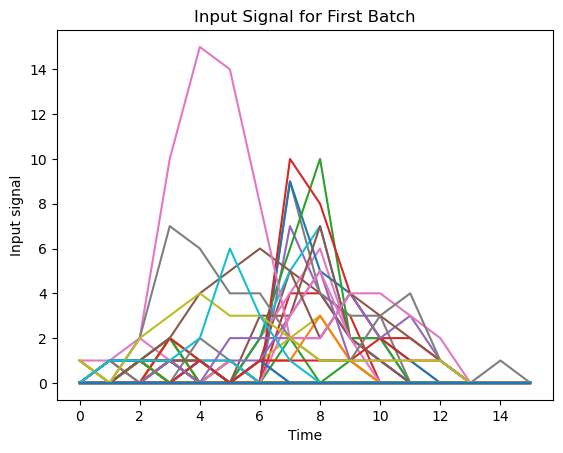

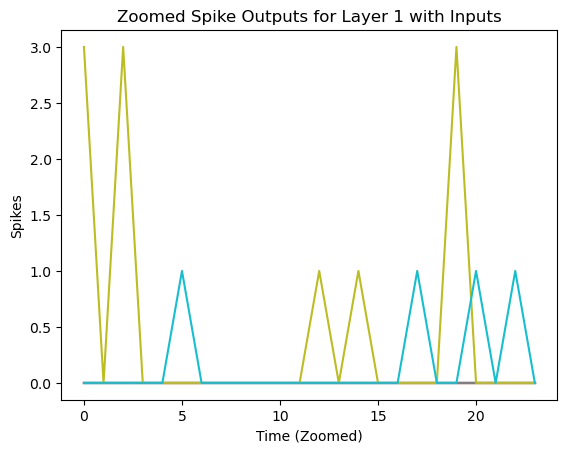

In [42]:
plt.plot(inputs[0, :, :].detach().cpu().numpy().T)  
plt.xlabel("Time")
plt.ylabel("Input signal")
plt.title("Input Signal for First Batch")
plt.show()

# compare with spike and membrane potential from one of the hidden layers
plt.plot(spike_hidden_layer_zoomed.T)
plt.xlabel("Time (Zoomed)")
plt.ylabel("Spikes")
plt.title(f"Zoomed Spike Outputs for Layer {layer_to_plot_hidden} with Inputs")
plt.show()


Visualizing background sample...
Spike data for Background sample (label 0):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


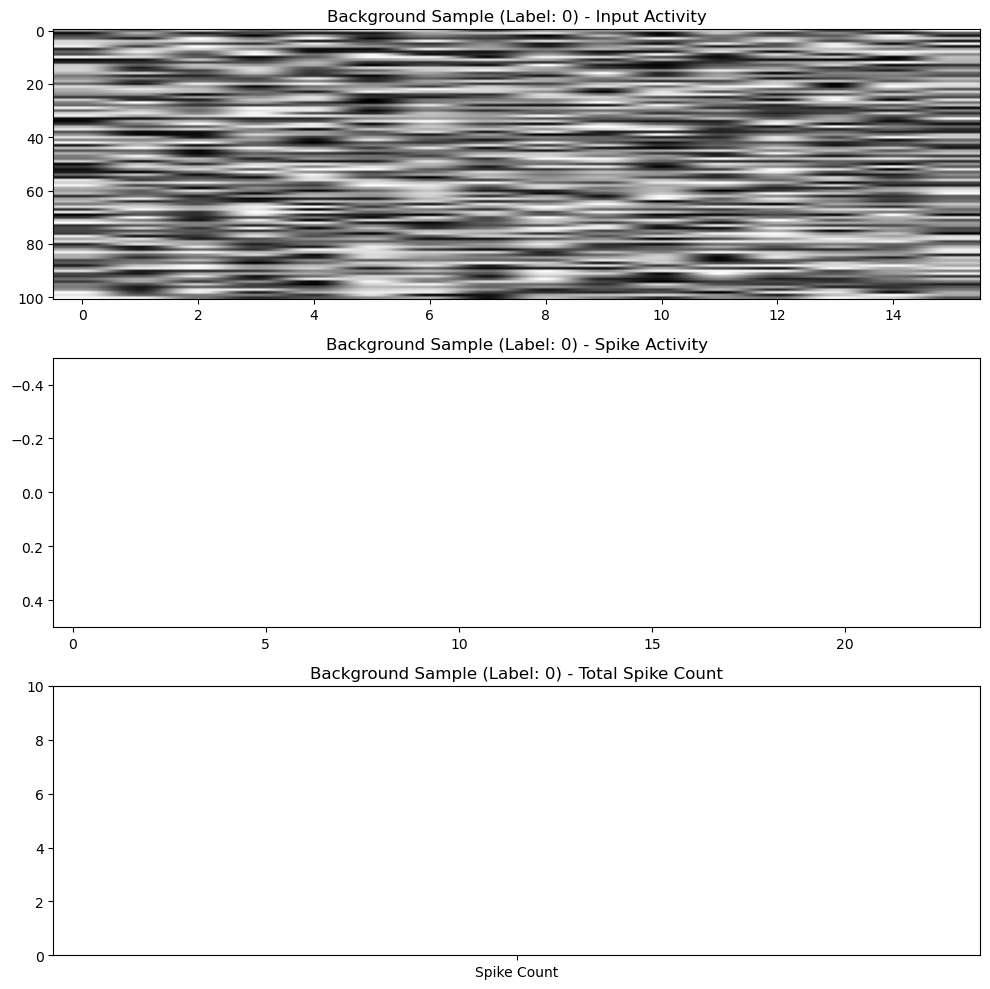

Visualizing target sample...
Spike data for Target sample (label 1):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


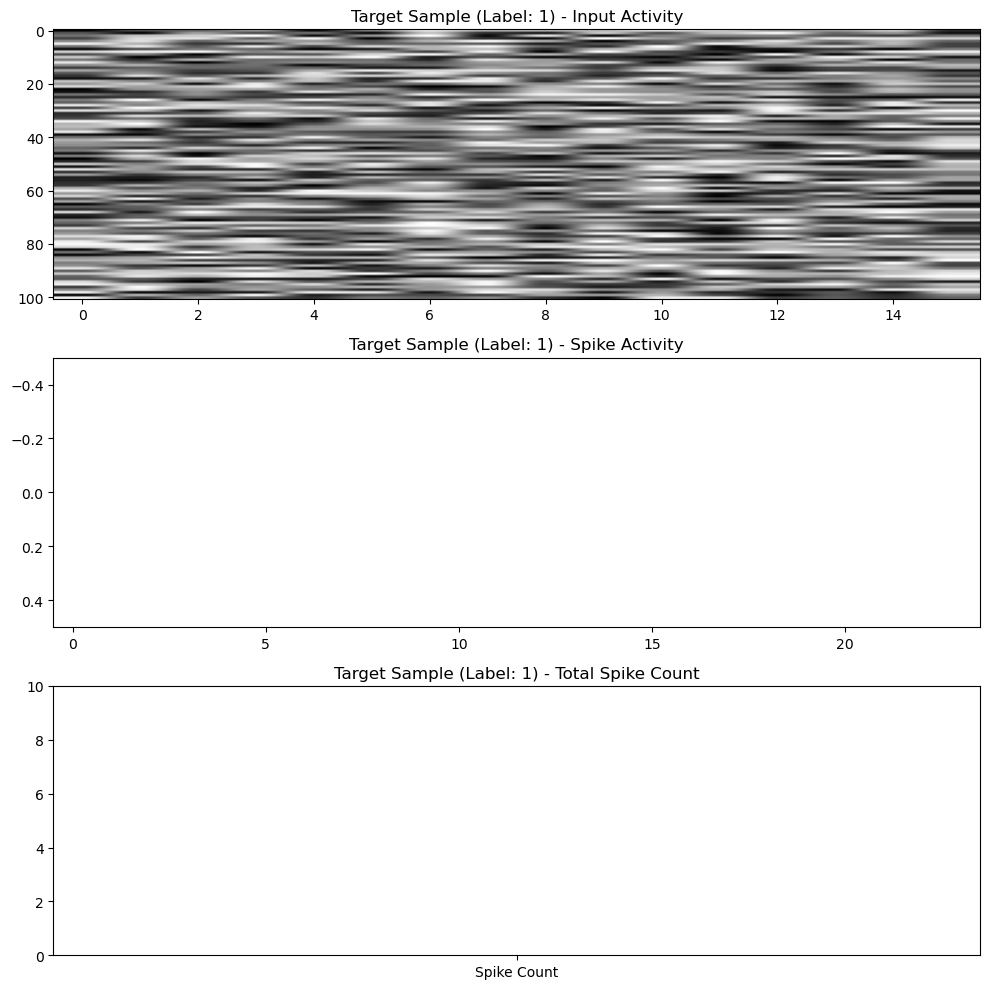

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize spikes and spike count for binary classification
def visualize_activity(inputs, spikes, outputs_sum, sample_label, sample_type):
    time_steps = inputs.shape[1]  # Number of time steps
    fig, axes = plt.subplots(3, 1, figsize=(10, 10))

    # Plot inputs
    axes[0].imshow(inputs.T, aspect='auto', cmap='gray_r')
    axes[0].set_title(f'{sample_type} Sample (Label: {sample_label}) - Input Activity')

    # Debugging: Print spike values to check if there are any non-zero spikes
    print(f"Spike data for {sample_type} sample (label {sample_label}):")
    print(spikes)

    # Check if spikes are 1D, and reshape to 2D
    if spikes.ndim == 1:
        spikes = spikes.reshape(-1, 1)  # Reshape to (n_neurons, 1)

    # Plot spike activity (spike train)
    axes[1].imshow(spikes.T, aspect='auto', cmap='binary')
    axes[1].set_title(f'{sample_type} Sample (Label: {sample_label}) - Spike Activity')

    # Plot total spike count (summed over time)
    axes[2].bar([0], [outputs_sum.item()], width=0.5, color='blue')
    axes[2].set_title(f'{sample_type} Sample (Label: {sample_label}) - Total Spike Count')
    axes[2].set_ylim([0, 10])  
    axes[2].set_xticks([0])
    axes[2].set_xticklabels(['Spike Count'])

    plt.tight_layout()
    plt.show()

for i, (v_mem, spikes) in enumerate(zip(membrane_potentials, spike_outputs)):
    if i == 0:  # Visualize for the first background sample
        inputs = np.random.rand(16, 101) 
        outputs_sum = spikes.sum()  # Summing over all time steps for binary classification
        print("Visualizing background sample...")
        visualize_activity(inputs, spikes, outputs_sum, sample_label=0, sample_type="Background")
    
    if i == 1:  # Visualize for the first target sample
        inputs = np.random.rand(16, 101) 
        outputs_sum = spikes.sum()
        print("Visualizing target sample...")
        visualize_activity(inputs, spikes, outputs_sum, sample_label=1, sample_type="Target")


### Model 2
- Added dropout of 0.1

In [64]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

n_channels = 16  
n_classes = 1   
n_time = 101     

model2 = SynNet(
    p_dropout = 0.1,
    n_channels=n_channels,                        
    n_classes=n_classes,                           
    size_hidden_layers=[24, 24, 24],        
    time_constants_per_layer=[2, 4, 8]
)

  0%|          | 0/50 [00:00<?, ?it/s]

Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5920289158821106
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.3892422914505005
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.02218337170779705
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -0.0030603178311139345
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 0.0
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4049350321292877
Inputs max: 26.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.4885001480579376
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.00275893765501678
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -0.014171796850860119
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 0.0
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([3

  2%|▏         | 1/50 [00:15<12:56, 15.84s/it]

Epoch 1/50, Training Loss: 65.08962264150944, Validation Loss: 193.36607142857142
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.40913134813308716
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.000708920182660222
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.0006624692468903959
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -0.7466294169425964
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: 0.21242499351501465
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4504757225513458
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.07192914932966232
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: 0.004374594893306494
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -0.43209636211395264
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIF

  4%|▍         | 2/50 [00:30<12:11, 15.25s/it]

Epoch 2/50, Training Loss: 63.823113207547166, Validation Loss: 54.839285714285715
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4408261179924011
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.502315640449524
Layer 1_LIFTorch: Spikes sum: 5.0
Layer 4_LIFTorch: Membrane potentials mean: -0.3014709949493408
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -1.9570059776306152
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 2.9580786365984995e-33
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.41048499941825867
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.3718433365284e-05
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: 0.006040343549102545
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -1.6367512941360474
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTo

  6%|▌         | 3/50 [00:45<11:50, 15.12s/it]

Epoch 3/50, Training Loss: 45.145636792452834, Validation Loss: 69.68303571428571
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5101330280303955
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.8218038082122803
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -0.1890106350183487
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -2.6681811809539795
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 1.4235995476948401e-18
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.6480700969696045
Inputs max: 27.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.038476452231407166
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.002222886774688959
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -1.324076533317566
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTo

  8%|▊         | 4/50 [01:00<11:32, 15.06s/it]

Epoch 4/50, Training Loss: 41.642099056603776, Validation Loss: 43.174107142857146
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.47354578971862793
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0329953208565712
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.1502053588628769
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.85162878036499
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.002762241754680872
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.521929144859314
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.1263970136642456
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -0.5014618039131165
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -3.44488263130188
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Me

 10%|█         | 5/50 [01:15<11:18, 15.07s/it]

Epoch 5/50, Training Loss: 39.535377358490564, Validation Loss: 57.57142857142857
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4686533212661743
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.21932493150234222
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.1944451481103897
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.899764537811279
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: -0.02748716250061989
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4741452634334564
Inputs max: 27.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.2625075578689575
Layer 1_LIFTorch: Spikes sum: 5.0
Layer 4_LIFTorch: Membrane potentials mean: -0.3675263226032257
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -8.13724422454834
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Me

 12%|█▏        | 6/50 [01:30<11:01, 15.03s/it]

Epoch 6/50, Training Loss: 36.06132075471698, Validation Loss: 35.401785714285715
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5051825642585754
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.6040926575660706
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -1.1722217798233032
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -9.146954536437988
Layer 7_LIFTorch: Spikes sum: 3.0
Layer 10_LIFTorch: Membrane potentials mean: 0.381153404712677
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4616529941558838
Inputs max: 26.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -2.4627022743225098
Layer 1_LIFTorch: Spikes sum: 10.0
Layer 4_LIFTorch: Membrane potentials mean: -2.1346795558929443
Layer 4_LIFTorch: Spikes sum: 11.0
Layer 7_LIFTorch: Membrane potentials mean: -9.973771095275879
Layer 7_LIFTorch: Spikes sum: 5.0
Layer 10_LIFTorch: Mem

 14%|█▍        | 7/50 [01:45<10:45, 15.01s/it]

Epoch 7/50, Training Loss: 33.64268867924528, Validation Loss: 36.299107142857146
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.48188042640686035
Inputs max: 37.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.888643741607666
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -0.9197675585746765
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -8.250359535217285
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: 0.043604884296655655
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.36214032769203186
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0025889165699481964
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.442008376121521
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -12.57092571258545
Layer 7_LIFTorch: Spikes sum: 2.0
Layer 10_LIFTorch:

 16%|█▌        | 8/50 [02:00<10:30, 15.02s/it]

Epoch 8/50, Training Loss: 33.86497641509434, Validation Loss: 35.169642857142854
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.41145187616348267
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.9077834486961365
Layer 1_LIFTorch: Spikes sum: 6.0
Layer 4_LIFTorch: Membrane potentials mean: -0.7111825346946716
Layer 4_LIFTorch: Spikes sum: 2.0
Layer 7_LIFTorch: Membrane potentials mean: -10.306212425231934
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: -0.15991941094398499
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.46294865012168884
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 1.0916035463786125e-13
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.0007296181283891201
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.557343006134033
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIF

 18%|█▊        | 9/50 [02:15<10:15, 15.02s/it]

Epoch 9/50, Training Loss: 31.840801886792452, Validation Loss: 24.486607142857142
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5068455934524536
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.384141206741333
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.04382457211613655
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.232408046722412
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -7.671973549532521e-25
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.48833927512168884
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.08268412947654724
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.21555499732494354
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -3.8852899074554443
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTo

 20%|██        | 10/50 [02:30<10:00, 15.02s/it]

Epoch 10/50, Training Loss: 29.340801886792452, Validation Loss: 27.209821428571427
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.42216506600379944
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.08927790075540543
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -1.03821861743927
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.436978816986084
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 1.4699615348945372e-05
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4964804947376251
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.1129231452941895
Layer 1_LIFTorch: Spikes sum: 10.0
Layer 4_LIFTorch: Membrane potentials mean: -0.802737295627594
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -7.766316890716553
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch

 22%|██▏       | 11/50 [02:45<09:46, 15.03s/it]

Epoch 11/50, Training Loss: 27.632075471698112, Validation Loss: 25.267857142857142
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.35514000058174133
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0008146483451128006
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.03153921291232109
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.101808547973633
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -6.321711225609761e-07
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5472424030303955
Inputs max: 35.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.12970897555351257
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.33244964480400085
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.842360973358154
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_L

 24%|██▍       | 12/50 [03:00<09:30, 15.02s/it]

Epoch 12/50, Training Loss: 28.09610849056604, Validation Loss: 24.5
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5080058574676514
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.11466970294713974
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.25154390931129456
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -12.065770149230957
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: -0.3322112560272217
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.42669013142585754
Inputs max: 38.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.35440191626548767
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -0.7862706780433655
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -12.316566467285156
Layer 7_LIFTorch: Spikes sum: 3.0
Layer 10_LIFTorch: Membrane p

 26%|██▌       | 13/50 [03:15<09:15, 15.03s/it]

Epoch 13/50, Training Loss: 26.87735849056604, Validation Loss: 22.089285714285715
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.48176437616348267
Inputs max: 37.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.012762997299432755
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.09707122296094894
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -5.680835723876953
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 0.047363147139549255
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.46658414602279663
Inputs max: 38.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.8419567942619324
Layer 1_LIFTorch: Spikes sum: 4.0
Layer 4_LIFTorch: Membrane potentials mean: -1.3285967111587524
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -7.805187702178955
Layer 7_LIFTorch: Spikes sum: 3.0
Layer 10_LIFTor

 28%|██▊       | 14/50 [03:30<09:00, 15.00s/it]

Epoch 14/50, Training Loss: 25.326650943396228, Validation Loss: 22.660714285714285
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5245784521102905
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.002365359803661704
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.264438658952713
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -5.290251731872559
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -2.8773201084299656e-25
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4190903604030609
Inputs max: 37.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.013234931044280529
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.18289387226104736
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -7.306278228759766
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIF

 30%|███       | 15/50 [03:45<08:46, 15.03s/it]

Epoch 15/50, Training Loss: 25.10200471698113, Validation Loss: 27.03125
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5467976331710815
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.04212019965052605
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.6685280203819275
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -11.069656372070312
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.14638112485408783
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3813234865665436
Inputs max: 50.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.4162214994430542
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -4.4544548988342285
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -14.04712200164795
Layer 7_LIFTorch: Spikes sum: 2.0
Layer 10_LIFTorch: Membrane 

 32%|███▏      | 16/50 [04:00<08:31, 15.04s/it]

Epoch 16/50, Training Loss: 26.59551886792453, Validation Loss: 22.401785714285715
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4028465449810028
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0020532996859401464
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.2154042273759842
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -8.820627212524414
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.11042103171348572
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.42438891530036926
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.25982344150543213
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.7668943405151367
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -7.351810455322266
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTor

 34%|███▍      | 17/50 [04:15<08:16, 15.05s/it]

Epoch 17/50, Training Loss: 24.81426886792453, Validation Loss: 20.821428571428573
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.43487006425857544
Inputs max: 26.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.012497697956860065
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -2.0415165424346924
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -8.591364860534668
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 0.019013961777091026
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3513304591178894
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.032121311873197556
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.33697018027305603
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.16245698928833
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorc

 36%|███▌      | 18/50 [04:31<08:02, 15.09s/it]

Epoch 18/50, Training Loss: 23.180424528301888, Validation Loss: 20.741071428571427
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.42081141471862793
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.0338398218154907
Layer 1_LIFTorch: Spikes sum: 8.0
Layer 4_LIFTorch: Membrane potentials mean: -4.721505641937256
Layer 4_LIFTorch: Spikes sum: 5.0
Layer 7_LIFTorch: Membrane potentials mean: -11.65283203125
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: -0.18788564205169678
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4658106565475464
Inputs max: 26.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.3739585876464844
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -1.1745611429214478
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -8.723416328430176
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Mem

 38%|███▊      | 19/50 [04:46<07:48, 15.10s/it]

Epoch 19/50, Training Loss: 23.598466981132077, Validation Loss: 20.96875
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.6773476004600525
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.14220571517944336
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.6998279094696045
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -7.021158695220947
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 4.459651337183467e-15
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.47443532943725586
Inputs max: 24.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.679386556148529
Layer 1_LIFTorch: Spikes sum: 6.0
Layer 4_LIFTorch: Membrane potentials mean: -6.209216594696045
Layer 4_LIFTorch: Spikes sum: 6.0
Layer 7_LIFTorch: Membrane potentials mean: -12.309329986572266
Layer 7_LIFTorch: Spikes sum: 3.0
Layer 10_LIFTorch: Membrane

 40%|████      | 20/50 [05:01<07:34, 15.14s/it]

Epoch 20/50, Training Loss: 23.37323113207547, Validation Loss: 22.138392857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.41350170969963074
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.00023265283380169421
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.2634396255016327
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -5.984647750854492
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -1.019131175310574e-26
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3871828615665436
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.10798314958810806
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -1.4234676361083984
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -8.928120613098145
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFT

 42%|████▏     | 21/50 [05:16<07:16, 15.04s/it]

Epoch 21/50, Training Loss: 24.358490566037737, Validation Loss: 21.415178571428573
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.38519105315208435
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.2433806657791138
Layer 1_LIFTorch: Spikes sum: 10.0
Layer 4_LIFTorch: Membrane potentials mean: -7.993627548217773
Layer 4_LIFTorch: Spikes sum: 7.0
Layer 7_LIFTorch: Membrane potentials mean: -11.014569282531738
Layer 7_LIFTorch: Spikes sum: 2.0
Layer 10_LIFTorch: Membrane potentials mean: 0.2933923006057739
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4260132908821106
Inputs max: 38.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.01969938911497593
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.18184012174606323
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -9.735564231872559
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch:

 44%|████▍     | 22/50 [05:30<06:57, 14.91s/it]

Epoch 22/50, Training Loss: 24.28242924528302, Validation Loss: 20.584821428571427
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.45463335514068604
Inputs max: 39.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.015832165256142616
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.37765514850616455
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -5.532087802886963
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -7.188787370399468e-25
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.34831374883651733
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.023916656151413918
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.04382794722914696
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.143924236297607
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LI

 46%|████▌     | 23/50 [05:45<06:40, 14.82s/it]

Epoch 23/50, Training Loss: 22.89445754716981, Validation Loss: 19.455357142857142
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.49298036098480225
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.1602732092142105
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.8520123362541199
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -16.651893615722656
Layer 7_LIFTorch: Spikes sum: 2.0
Layer 10_LIFTorch: Membrane potentials mean: -0.49584269523620605
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5127436518669128
Inputs max: 39.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.4622388780117035
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.6535182595252991
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -7.135288238525391
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch:

 48%|████▊     | 24/50 [06:00<06:23, 14.74s/it]

Epoch 24/50, Training Loss: 21.94693396226415, Validation Loss: 18.183035714285715
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.48321473598480225
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.15866772830486298
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -4.790945053100586
Layer 4_LIFTorch: Spikes sum: 2.0
Layer 7_LIFTorch: Membrane potentials mean: -13.36854076385498
Layer 7_LIFTorch: Spikes sum: 3.0
Layer 10_LIFTorch: Membrane potentials mean: 0.004503659904003143
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5712020397186279
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.03723977133631706
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.8164623379707336
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -6.572312831878662
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch:

 50%|█████     | 25/50 [06:14<06:06, 14.68s/it]

Epoch 25/50, Training Loss: 21.85318396226415, Validation Loss: 18.232142857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.509456217288971
Inputs max: 39.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.252916932106018
Layer 1_LIFTorch: Spikes sum: 9.0
Layer 4_LIFTorch: Membrane potentials mean: -6.644067764282227
Layer 4_LIFTorch: Spikes sum: 5.0
Layer 7_LIFTorch: Membrane potentials mean: -8.148347854614258
Layer 7_LIFTorch: Spikes sum: 2.0
Layer 10_LIFTorch: Membrane potentials mean: 0.1142304390668869
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3989596366882324
Inputs max: 25.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.002073487965390086
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.9359419345855713
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -8.20833969116211
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membr

 52%|█████▏    | 26/50 [06:29<05:54, 14.75s/it]

Epoch 26/50, Training Loss: 21.95931603773585, Validation Loss: 23.950892857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3666073679924011
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.4294660985469818
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.7904771566390991
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -13.526747703552246
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: -0.1911906898021698
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.37995049357414246
Inputs max: 24.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.02010313607752323
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.9088616371154785
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -12.954174995422363
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch:

 54%|█████▍    | 27/50 [06:44<05:37, 14.69s/it]

Epoch 27/50, Training Loss: 22.090212264150942, Validation Loss: 19.558035714285715
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.43815749883651733
Inputs max: 38.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.014609145931899548
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.10230309516191483
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -9.201531410217285
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.0002840552479028702
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4521194398403168
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.4553392231464386
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -4.61161470413208
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -7.3100152015686035
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTor

 56%|█████▌    | 28/50 [06:58<05:22, 14.66s/it]

Epoch 28/50, Training Loss: 21.434551886792452, Validation Loss: 20.78125
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4760403633117676
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.14202626049518585
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -4.511414051055908
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -12.087413787841797
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 0.00016134214820340276
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5082765817642212
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.024745037779211998
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -4.303443431854248
Layer 4_LIFTorch: Spikes sum: 2.0
Layer 7_LIFTorch: Membrane potentials mean: -10.065836906433105
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membr

 58%|█████▊    | 29/50 [07:13<05:08, 14.70s/it]

Epoch 29/50, Training Loss: 21.142688679245282, Validation Loss: 18.486607142857142
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5874071717262268
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.34946098923683167
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -10.218152046203613
Layer 4_LIFTorch: Spikes sum: 4.0
Layer 7_LIFTorch: Membrane potentials mean: -14.037894248962402
Layer 7_LIFTorch: Spikes sum: 2.0
Layer 10_LIFTorch: Membrane potentials mean: 0.3559207022190094
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.34197092056274414
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0018875611713156104
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.6481224298477173
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -10.316158294677734
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTo

 60%|██████    | 30/50 [07:28<04:53, 14.66s/it]

Epoch 30/50, Training Loss: 21.04127358490566, Validation Loss: 19.816964285714285
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5262801647186279
Inputs max: 38.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.03451584279537201
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.9358757138252258
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -8.102195739746094
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -3.0633880669483915e-05
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3956141769886017
Inputs max: 26.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.12014183402061462
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.0507032871246338
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -9.04799747467041
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorc

 62%|██████▏   | 31/50 [07:42<04:37, 14.63s/it]

Epoch 31/50, Training Loss: 21.079599056603772, Validation Loss: 19.71875
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3420289158821106
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.5447607636451721
Layer 1_LIFTorch: Spikes sum: 4.0
Layer 4_LIFTorch: Membrane potentials mean: -4.479753017425537
Layer 4_LIFTorch: Spikes sum: 2.0
Layer 7_LIFTorch: Membrane potentials mean: -6.978729724884033
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -1.6211598507053155e-26
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.37687578797340393
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.0005111902137286961
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.39547157287597656
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.559835433959961
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Memb

 64%|██████▍   | 32/50 [07:57<04:23, 14.66s/it]

Epoch 32/50, Training Loss: 20.70990566037736, Validation Loss: 19.513392857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.33419710397720337
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -4.7796101570129395
Layer 1_LIFTorch: Spikes sum: 33.0
Layer 4_LIFTorch: Membrane potentials mean: -17.659788131713867
Layer 4_LIFTorch: Spikes sum: 14.0
Layer 7_LIFTorch: Membrane potentials mean: -12.152531623840332
Layer 7_LIFTorch: Spikes sum: 5.0
Layer 10_LIFTorch: Membrane potentials mean: 0.006141364574432373
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4712252616882324
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0007071022992022336
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.9325934648513794
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -5.705152988433838
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFT

 66%|██████▌   | 33/50 [08:11<04:08, 14.64s/it]

Epoch 33/50, Training Loss: 21.317806603773583, Validation Loss: 21.651785714285715
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3299621045589447
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.2562048137187958
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -3.5554676055908203
Layer 4_LIFTorch: Spikes sum: 2.0
Layer 7_LIFTorch: Membrane potentials mean: -8.687642097473145
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -2.596590720216341e-10
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5968827605247498
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.07288851588964462
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -4.604899883270264
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -8.41256332397461
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch:

 68%|██████▊   | 34/50 [08:26<03:54, 14.63s/it]

Epoch 34/50, Training Loss: 20.005306603773583, Validation Loss: 18.839285714285715
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.45892634987831116
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.626472532749176
Layer 1_LIFTorch: Spikes sum: 2.0
Layer 4_LIFTorch: Membrane potentials mean: -2.329087018966675
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -10.036821365356445
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.08157521486282349
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.43670713901519775
Inputs max: 25.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.6613601446151733
Layer 1_LIFTorch: Spikes sum: 9.0
Layer 4_LIFTorch: Membrane potentials mean: -8.429665565490723
Layer 4_LIFTorch: Spikes sum: 5.0
Layer 7_LIFTorch: Membrane potentials mean: -11.63876724243164
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: 

 70%|███████   | 35/50 [08:41<03:39, 14.64s/it]

Epoch 35/50, Training Loss: 19.838443396226417, Validation Loss: 18.727678571428573
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.38422417640686035
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0009341980912722647
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.2139531522989273
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -7.698441982269287
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.019062139093875885
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.39201733469963074
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.9799723625183105
Layer 1_LIFTorch: Spikes sum: 3.0
Layer 4_LIFTorch: Membrane potentials mean: -8.711112022399902
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -8.385052680969238
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTo

 72%|███████▏  | 36/50 [08:55<03:25, 14.67s/it]

Epoch 36/50, Training Loss: 18.963443396226417, Validation Loss: 18.705357142857142
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.40982750058174133
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.007979943417012691
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.8816412091255188
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -11.240694999694824
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.0007692332728765905
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.42121750116348267
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.012375096790492535
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.3641079366207123
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -8.973247528076172
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LI

 74%|███████▍  | 37/50 [09:10<03:10, 14.66s/it]

Epoch 37/50, Training Loss: 20.775353773584907, Validation Loss: 18.584821428571427
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.6171875
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.4144890010356903
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -4.037262439727783
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -11.36087417602539
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.015227552503347397
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5004060864448547
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.026601267978549004
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -2.0606865882873535
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -9.254607200622559
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membran

 76%|███████▌  | 38/50 [09:25<02:55, 14.66s/it]

Epoch 38/50, Training Loss: 19.08431603773585, Validation Loss: 20.4375
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.42887529730796814
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.8399970531463623
Layer 1_LIFTorch: Spikes sum: 5.0
Layer 4_LIFTorch: Membrane potentials mean: -6.253345966339111
Layer 4_LIFTorch: Spikes sum: 5.0
Layer 7_LIFTorch: Membrane potentials mean: -9.72500991821289
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -0.006185103207826614
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5091274976730347
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 3.513141564326361e-07
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.005470493342727423
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.115149021148682
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane

 78%|███████▊  | 39/50 [09:39<02:41, 14.66s/it]

Epoch 39/50, Training Loss: 19.086674528301888, Validation Loss: 18.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.43757733702659607
Inputs max: 25.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.3752363920211792
Layer 1_LIFTorch: Spikes sum: 9.0
Layer 4_LIFTorch: Membrane potentials mean: -10.76904582977295
Layer 4_LIFTorch: Spikes sum: 5.0
Layer 7_LIFTorch: Membrane potentials mean: -13.876587867736816
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: 0.1511603146791458
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5850672721862793
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.005256075877696276
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.7128934860229492
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -9.209640502929688
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane pote

 80%|████████  | 40/50 [09:54<02:27, 14.71s/it]

Epoch 40/50, Training Loss: 18.625, Validation Loss: 24.660714285714285
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.38981279730796814
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.24351944029331207
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -2.8623135089874268
Layer 4_LIFTorch: Spikes sum: 2.0
Layer 7_LIFTorch: Membrane potentials mean: -8.33389663696289
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: -9.682451462822428e-08
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3958849012851715
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.008916663937270641
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.24135763943195343
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.955801010131836
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membran

 82%|████████▏ | 41/50 [10:09<02:12, 14.69s/it]

Epoch 41/50, Training Loss: 19.36733490566038, Validation Loss: 17.888392857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4109877645969391
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.023309165611863136
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.03908360004425049
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -5.304950714111328
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 8.137169570832735e-27
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5227026343345642
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0326143354177475
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.7100728750228882
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -7.04263162612915
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch:

 84%|████████▍ | 42/50 [10:24<01:57, 14.74s/it]

Epoch 42/50, Training Loss: 18.129127358490567, Validation Loss: 16.821428571428573
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4378867447376251
Inputs max: 30.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.09629219770431519
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.8719215393066406
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -12.180161476135254
Layer 7_LIFTorch: Spikes sum: 3.0
Layer 10_LIFTorch: Membrane potentials mean: -0.9614755511283875
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.48002398014068604
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.013481110334396362
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.001266546081751585
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -4.929803848266602
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTo

 86%|████████▌ | 43/50 [10:38<01:43, 14.74s/it]

Epoch 43/50, Training Loss: 18.388561320754718, Validation Loss: 17.450892857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4746287167072296
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -1.6568552255630493
Layer 1_LIFTorch: Spikes sum: 15.0
Layer 4_LIFTorch: Membrane potentials mean: -10.678608894348145
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -11.938709259033203
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: 0.1801948845386505
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.36125078797340393
Inputs max: 29.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.33012324571609497
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -5.529527187347412
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -12.899574279785156
Layer 7_LIFTorch: Spikes sum: 3.0
Layer 10_LIFTorch

 88%|████████▊ | 44/50 [10:53<01:28, 14.71s/it]

Epoch 44/50, Training Loss: 19.57134433962264, Validation Loss: 17.790178571428573
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.41094911098480225
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.0537535697221756
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.20810560882091522
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -5.444549083709717
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 8.115264814017252e-27
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4295521378517151
Inputs max: 44.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 3.8520288399013225e-06
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.46490535140037537
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -7.021382808685303
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFT

 90%|█████████ | 45/50 [11:08<01:13, 14.69s/it]

Epoch 45/50, Training Loss: 21.349646226415093, Validation Loss: 15.964285714285714
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4316212832927704
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -7.3339324444532394e-06
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.3731725215911865
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -9.344456672668457
Layer 7_LIFTorch: Spikes sum: 1.0
Layer 10_LIFTorch: Membrane potentials mean: -0.2077847570180893
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.6611811518669128
Inputs max: 32.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.6910996437072754
Layer 1_LIFTorch: Spikes sum: 6.0
Layer 4_LIFTorch: Membrane potentials mean: -6.110194683074951
Layer 4_LIFTorch: Spikes sum: 3.0
Layer 7_LIFTorch: Membrane potentials mean: -5.056910991668701
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch

 92%|█████████▏| 46/50 [11:22<00:58, 14.67s/it]

Epoch 46/50, Training Loss: 21.03891509433962, Validation Loss: 16.825892857142858
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.48884204030036926
Inputs max: 31.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.01735486090183258
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.124200463294983
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -14.032055854797363
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 1.532970657081023e-07
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.4856899678707123
Inputs max: 24.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.20326662063598633
Layer 1_LIFTorch: Spikes sum: 1.0
Layer 4_LIFTorch: Membrane potentials mean: -3.889122724533081
Layer 4_LIFTorch: Spikes sum: 1.0
Layer 7_LIFTorch: Membrane potentials mean: -12.730380058288574
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorc

 94%|█████████▍| 47/50 [11:37<00:44, 14.72s/it]

Epoch 47/50, Training Loss: 18.955188679245282, Validation Loss: 22.285714285714285
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.5365872383117676
Inputs max: 34.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.05170712247490883
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.4267863035202026
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -12.890655517578125
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 7.737406093610844e-08
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.512163519859314
Inputs max: 38.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.7449833750724792
Layer 1_LIFTorch: Spikes sum: 5.0
Layer 4_LIFTorch: Membrane potentials mean: -10.55250072479248
Layer 4_LIFTorch: Spikes sum: 6.0
Layer 7_LIFTorch: Membrane potentials mean: -20.7050724029541
Layer 7_LIFTorch: Spikes sum: 2.0
Layer 10_LIFTorch: 

 96%|█████████▌| 48/50 [11:52<00:29, 14.70s/it]

Epoch 48/50, Training Loss: 18.52063679245283, Validation Loss: 15.348214285714286
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.3456064462661743
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -0.04335852339863777
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.19329266250133514
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -7.116554260253906
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 2.5906051534572087e-27
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.42961016297340393
Inputs max: 33.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: -2.9141366481781006
Layer 1_LIFTorch: Spikes sum: 26.0
Layer 4_LIFTorch: Membrane potentials mean: -16.13414192199707
Layer 4_LIFTorch: Spikes sum: 14.0
Layer 7_LIFTorch: Membrane potentials mean: -11.603983879089355
Layer 7_LIFTorch: Spikes sum: 3.0
Layer 10_LIFT

 98%|█████████▊| 49/50 [12:06<00:14, 14.66s/it]

Epoch 49/50, Training Loss: 18.556603773584907, Validation Loss: 16.790178571428573
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.41228342056274414
Inputs max: 24.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.0036453083157539368
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -0.0564691461622715
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -7.02105188369751
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTorch: Membrane potentials mean: 3.547481683317635e-27
Layer 10_LIFTorch: Spikes sum: 0.0
Inputs shape: torch.Size([32, 101, 16])
Inputs mean: 0.37521272897720337
Inputs max: 28.0
Inputs min: 0.0
Layer 1_LIFTorch: Membrane potentials mean: 0.03399144113063812
Layer 1_LIFTorch: Spikes sum: 0.0
Layer 4_LIFTorch: Membrane potentials mean: -1.800036072731018
Layer 4_LIFTorch: Spikes sum: 0.0
Layer 7_LIFTorch: Membrane potentials mean: -10.225299835205078
Layer 7_LIFTorch: Spikes sum: 0.0
Layer 10_LIFTor

100%|██████████| 50/50 [12:21<00:00, 14.83s/it]

Epoch 50/50, Training Loss: 17.983490566037737, Validation Loss: 18.120535714285715


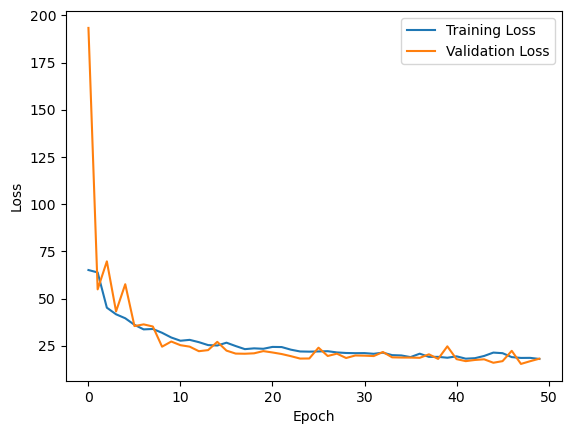

In [65]:
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

# Hyperparameters
n_epochs = 50
learning_rate = 1e-3
target_firing_rate_value = 10  

optimizer = Adam(model2.parameters().astorch(), lr=learning_rate)
loss_fun = MSELoss()

# Store losses for plotting
train_losses = []
val_losses = []

# Store membrane potentials, spikes, syn currents
membrane_potentials = []
spike_outputs = []
synaptic_currents = []

# Store predictions and ground truth
predictions = []
ground_truths = []

# Training phase
for epoch in trange(n_epochs):
    model2.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.permute(0, 2, 1).to(device)

        # Inspect the inputs
        print("Inputs shape:", inputs.shape)
        print("Inputs mean:", inputs.mean().item())
        print("Inputs max:", inputs.max().item())
        print("Inputs min:", inputs.min().item())

        optimizer.zero_grad()
        outputs, _, _ = model2(inputs)
        outputs_sum = outputs.sum(dim=1)  # Sum over the time dimension

        # target firing rate tensor
        target_firing_rate = torch.zeros_like(outputs_sum).to(device)
        target_firing_rate[labels == 1] = target_firing_rate_value
        target_firing_rate[labels == 0] = 0

        # Compute loss
        loss = loss_fun(outputs_sum, target_firing_rate)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if epoch == n_epochs - 1:
            predictions.append(outputs_sum.detach().cpu().numpy())  # Final output (spike prediction)
            ground_truths.append(labels.cpu().numpy()) 
        
        # Access internal layer membrane potentials and spikes
        for lyr_name in model2.lif_names:
            lyr = model2.seq[lyr_name]

            # Inspect membrane potentials and spikes
            print(f"Layer {lyr_name}: Membrane potentials mean:", lyr.vmem.mean().item())
            print(f"Layer {lyr_name}: Spikes sum:", lyr.spikes.sum().item())  # Sum of spikes should be > 0 if neurons are firing
            
            v_mem = lyr.vmem.detach().cpu().numpy()  # Membrane potentials
            spikes = lyr.spikes.detach().cpu().numpy()  # Spikes
            i_syn = lyr.isyn.detach().cpu().numpy()  # Synaptic currents
            
            # Store for visualization
            membrane_potentials.append(v_mem)
            spike_outputs.append(spikes)
            synaptic_currents.append(i_syn)

    train_losses.append(epoch_loss / len(train_loader))

    # Validation phase
    model2.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1).to(device)
            outputs, _, _ = model2(inputs)
            outputs_sum = outputs.sum(dim=1)
            target_firing_rate = torch.zeros_like(outputs_sum).to(device)
            target_firing_rate[labels == 1] = target_firing_rate_value
            target_firing_rate[labels == 0] = 0
            loss = loss_fun(outputs_sum, target_firing_rate)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

predictions = np.concatenate(predictions)
ground_truths = np.concatenate(ground_truths)

# Save results
model2_outputs = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'membrane_potentials': membrane_potentials,
    'spike_outputs': spike_outputs,
    'synaptic_currents': synaptic_currents,
    'predictions': predictions,  
    'ground_truths': ground_truths
}

with open('model2_outputs.pkl', 'wb') as f:
    pickle.dump(model2_outputs, f)
    
# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
